# Receiver Simulations

Simulating backscatter retrievals up to cloud boundaries. The simulations will include signals for high- and low-gain channels. The flux will follow the theory from 'photon_budget_calculation.ipynb'. 

This version differs from "meas_sim_v1.ipynb" in that it is now trying to incorporate temporal variability for the cloud base

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import time
import xarray as xr
import pickle
from pathlib import Path

# import library for simulating Poisson point processes
cwd = os.getcwd()
dirLib = cwd + r'/library'
if dirLib not in sys.path:
    sys.path.append(dirLib)

import sim_deadtime_utils as sim
from load_ARSENL_data import set_binwidth

eps = sys.float_info.epsilon

In [2]:
# Constants

c = 299792458  # [m/s] speed of light
k_B = 1.380649e-23  # [m^2 kg s-2 K-1]
g_0 = 9.81  # [m s-2] Gravity
M_air = 28.97  # [g/mol] Molar mass of air
R_0 = 8.314459  # [J/mol/K] Universal gas constant
N_A = 6.022e23  # [atoms / mol] Avogadro's number
h = 6.626e-34  # [J s] Planck's constant

L = 9e-3  # [K/km] Temperature lapse rate for Denver
P_0 = 840  # [mbar] Typical absolute pressure for Denver
T_0 = 294.3  # [K] Typical 70 F temperature for Denver
lamb = 532.18e-9  # [m] laser wavelength

D = 8  # [in] outer diameter of telescope
d = 1.8  # [in] inner diameter of telescope

dt_TCSPC = 25e-12  # [s] native resolution of TCSPC

# Laser specs
P_L = 35e-3  # [W] average laser power
dt_L = 700e-12  # [s] laser pulse FWHM
f_L = 14.7e3  # [Hz] rep rate

# Receiver specs (at 532 nm)
R_tele = 0.95  # Telescope reflectance
R_M = 0.99  # Folding mirror reflectance
T_L = 0.9  # Standard lens transmittance
mu_F = 0.994  # [m-1] Fiber transmission coefficient
L_F = 2  # [m] Fiber length
T_F = mu_F * L_F  # Fiber transmittance
T_FC = T_L  # Fiber coupler transmittance
T_BS_LG = 0.05  # Beam-splitter low-gain transmittance
T_BS_HG = 0.95  # Beam-splitter high-gain transmittance
T_SBF = 0.9  # Solar background filter transmittance
eta_QE = 0.5  # Detector quantum efficiency
loss = 10  # Unaccounted loss term

dalt = c * dt_TCSPC / 2  # [m]
alt = np.arange(eps, 2e3, dalt)  # [m] target range

### Molecular Signal

The molecular signal will serve as the background Rayleigh scattering. The aerosol signal (clouds) will follow.

In [3]:
# Calculate Temperature and Pressure
T = T_0 - L/1000*alt  # [K]

C_g = g_0*M_air/R_0/L
P = P_0 * (T/T_0)**C_g  # [mbar]

# Scattering coefficients
beta_mol = 2.938e-32 * P/T * lamb**(-4.0117)  # [m-1 sr-1]
alpha_mol = 8*np.pi/3 * beta_mol  # [m-1]

# Telescope parameters
A = np.pi/4*(D**2-d**2)  # [in^2]
A *= (0.0254**2)  # [m^2] Area

# Geometric overlap
# G = 1  # assumed one at furthest range
# Choose reasonable inverted exponential for asymptotic rise to 1 at some altitude
G_alt = np.arange(min(alt)-500, round(max(alt)-500), dalt)
alpha = 0.05  # Time constant for exponential
G = (1 / (1+np.exp(-alpha*G_alt)))

# Range resolution
dR = c * dt_TCSPC / 2  # [m]

# Number of transmitted photons per shot
N_L = P_L/f_L/h/c*lamb
# N_L = 1.5e-6/h/c*lamb

# Receiver efficiency
eta = R_tele * R_M * T_L**4 * T_F * T_FC**2 * T_SBF * eta_QE / loss

# Background signal
N_B = 0  # number of background photons

# Generate photon-count expectation function

# Lidar equation for molecular backscatter
R = alt  # [m] assume transmitter and receiver are at the surface

trans = np.exp(-np.cumsum(alpha_mol*dR))

N_mol_LG = N_L*beta_mol*dR*A/R**2*trans**2*eta*T_BS_LG*G + N_B
N_mol_HG = N_L*beta_mol*dR*A/R**2*trans**2*eta*T_BS_HG*G + N_B

# # Account for unexpected missed photons (e.g., poor alignment)
# N_mol_LG /= 10
# N_mol_HG /= 10

# Remove first term (unreal, 0 km alt)
N_mol_LG[0] = 0
N_mol_HG[0] = 0

N_mol_LG_tot = np.sum(N_mol_LG)
N_mol_HG_tot = np.sum(N_mol_HG)

print('Total low gain photons: {:.2E}'.format(N_mol_LG_tot))
print('Total high gain photons: {:.2E}'.format(N_mol_HG_tot))

Total low gain photons: 7.26E-01
Total high gain photons: 1.38E+01


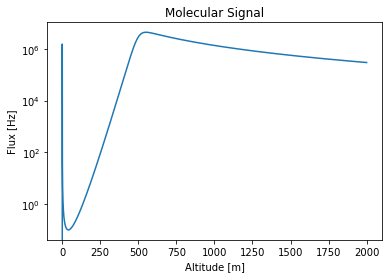

In [4]:
# Molecular (Rayleigh) signal
# Checking how the overlap function looks...

fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(alt, N_mol_HG/dt_TCSPC)
# ax.set_ylim([1, 10000])
ax.set_xlabel('Altitude [m]')
ax.set_ylabel('Flux [Hz]')
ax.set_title('Molecular Signal')
plt.show()

# Cloud Signal

In [5]:
def gen_cloud(alt, plat_height, cloud_bot, cloud_top, cloud_alpha, S, beta_aer, alpha_mol, beta_mol, dR, N_L, A, eta, G, N_B, dt):
    R = alt - plat_height  # [m] Remove platform height to convert to range
    
    cloud_sig = (1 / (1+np.exp(-cloud_alpha*(alt-cloud_bot)))) - (1 / (1+np.exp(-cloud_alpha*(alt-cloud_top))))
    cloud = np.ones(len(alt))
    cloud *= cloud_sig
    
    beta_aer *= cloud  # [m-1 sr-1]
    alpha_aer = S * beta_aer
        
    trans = np.exp(-np.cumsum((alpha_mol+alpha_aer)*dR))
    N_com = N_L*(beta_mol + beta_aer)*dR*A/R**2*trans**2*eta*G + N_B
    N_com[0] = 0

    rho_func = N_com / dt  # [Hz]
    photon_rate_arr = rho_func  # [Hz]
   
    return photon_rate_arr, N_com, cloud

C:\Users\Grant\AppData\Local\Temp\ipykernel_1732\1696672126.py:4: RuntimeWarning: overflow encountered in exp
  cloud_sig = (1 / (1+np.exp(-cloud_alpha*(alt-cloud_bot)))) - (1 / (1+np.exp(-cloud_alpha*(alt-cloud_top))))


Total low gain photons: 1.08E+01
Total high gain photons: 2.05E+02


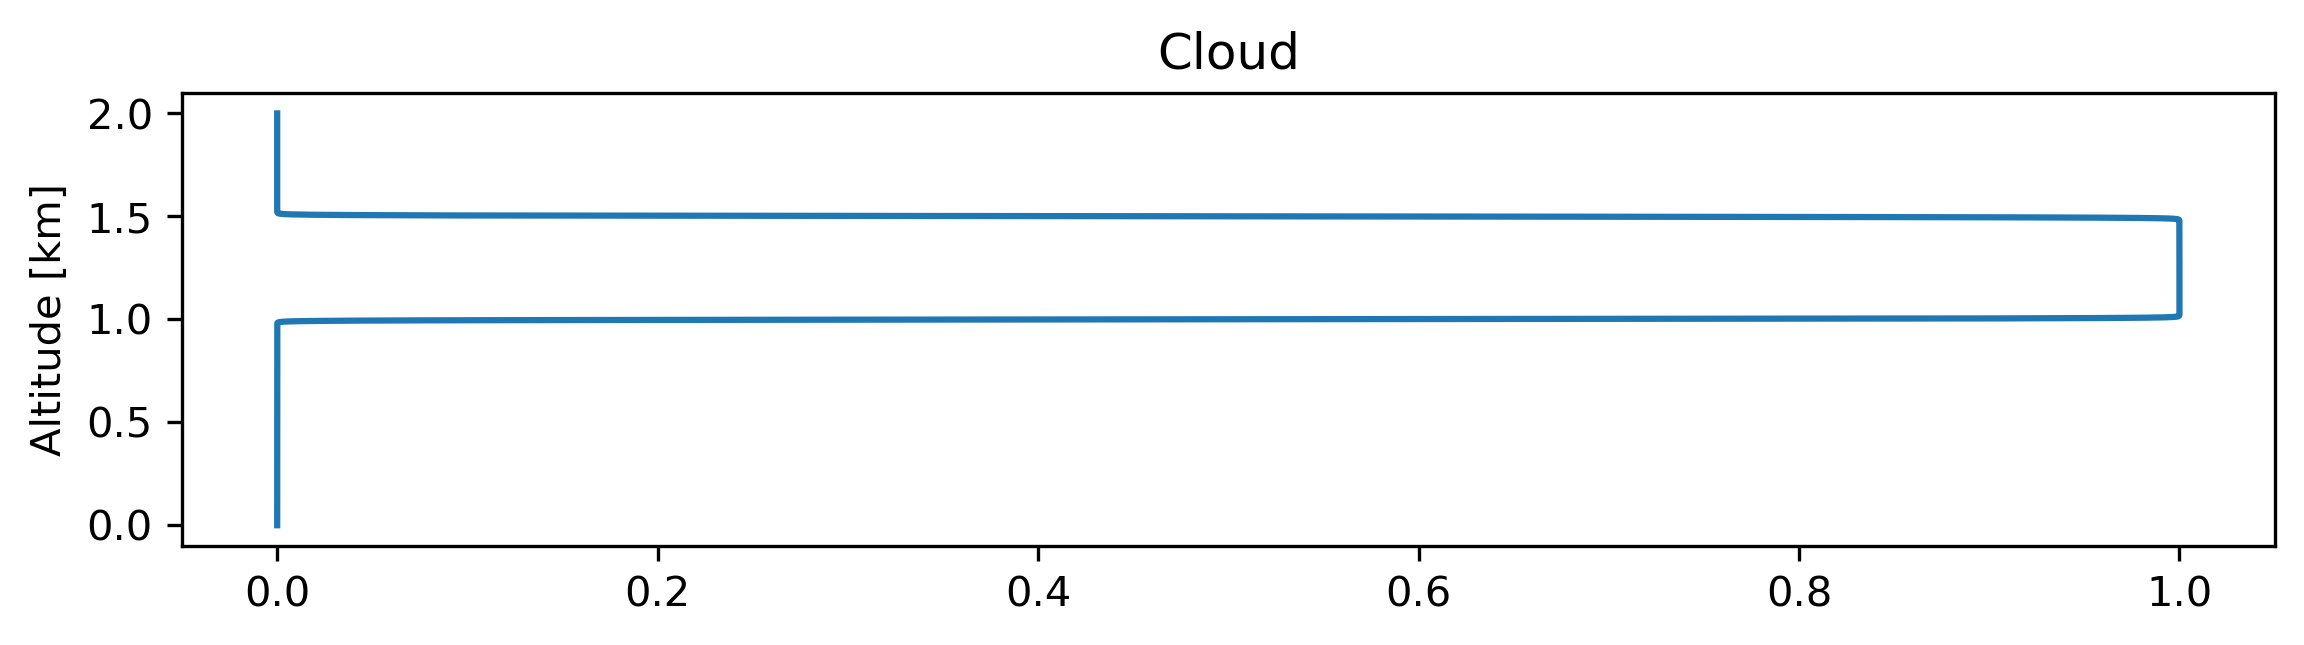

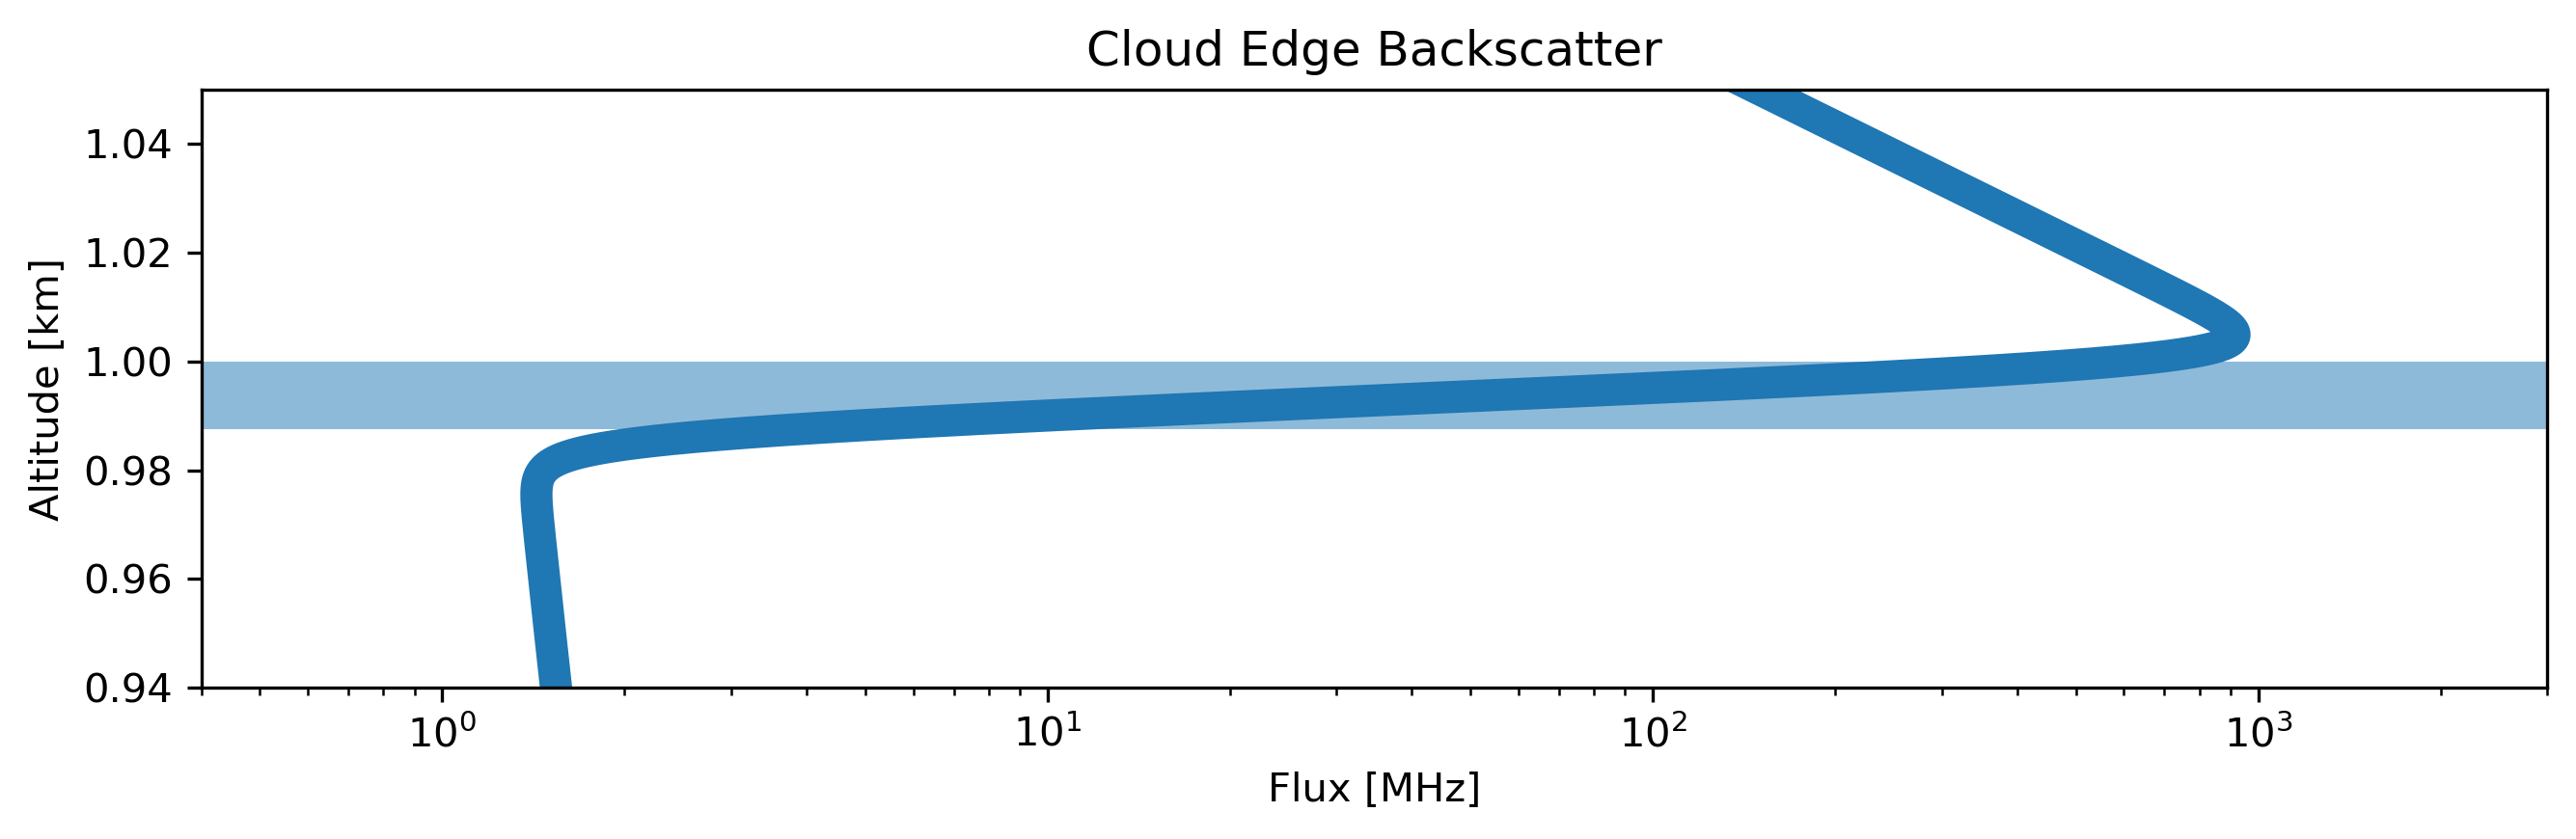

In [6]:
# Add cloud to signal

cloud_bot = 1.0e3  # [m] cloud base
cloud_top = 1.5e3  # [m] cloud top
cloud_alpha = 0.5  # sharp transition

plat_height = 0  # [m] Platform altitude
S = 20  # [sr] lidar ratio
# S = 40  # [sr] try this for rapid extinction
beta_aer = 1e-3  # [m-1 sr-1] singular value for aerosol backscatter

photon_rate_arr_LG, N_com_LG, cloud = gen_cloud(alt, plat_height, cloud_bot, cloud_top, cloud_alpha, S, beta_aer, alpha_mol, beta_mol, dR, N_L, A, eta*T_BS_LG, G, N_B, dt_TCSPC)
photon_rate_arr_HG, N_com_HG, cloud = gen_cloud(alt, plat_height, cloud_bot, cloud_top, cloud_alpha, S, beta_aer, alpha_mol, beta_mol, dR, N_L, A, eta*T_BS_HG, G, N_B, dt_TCSPC)

# # Unaccounted missed photons
# N_com_LG /= 10
# N_com_HG /= 10

N_com_LG_tot = np.sum(N_com_LG)
N_com_HG_tot = np.sum(N_com_HG)

print('Total low gain photons: {:.2E}'.format(N_com_LG_tot))
print('Total high gain photons: {:.2E}'.format(N_com_HG_tot))

# Check cloud + mol signal

fig = plt.figure(figsize=(9, 2), dpi=300)
ax = fig.add_subplot(111)
ax.plot(cloud, alt/1e3)
ax.set_ylabel('Altitude [km]')
ax.set_title('Cloud')
plt.show()

fig = plt.figure(figsize=(9, 3), dpi=300)
ax = fig.add_subplot(111)
ax.plot(N_com_HG/dt_TCSPC/1e6, R/1e3, '-', linewidth=8)
ax.set_ylabel('Altitude [km]')
ax.set_xlabel('Flux [MHz]')
ax.set_title('Cloud Edge Backscatter')
ax.set_xlim([4e-1, 3e3])
ax.set_ylim([0.94, 1.05])
ax.fill_between([4e-1, 3e3], 0.9875, 1.00, alpha=0.5)
ax.set_xscale('log')
plt.tight_layout()
plt.show()

### Generate simulated returns

Using Matt's code (same one I used for my deadtime experiments), generate simulated measurements using the arrival-rate function generated.

In [157]:
# Parameters for simulation. !!!Make sure to change simulation number for corresponding image!!!

sim_num = 10

Nshot = 1e5  # Number of laser shots

use_com = True
time_vary = False
use_hg = True
use_window = True

# tD = 29.1e-9  # [s] Deadtime interval
tD = 20e-9  # [s]
wrap_deadtime = False
window_bnd = [900, 1100]

amp = 5  # [m] sinusoid amplitude, if time_vary == True

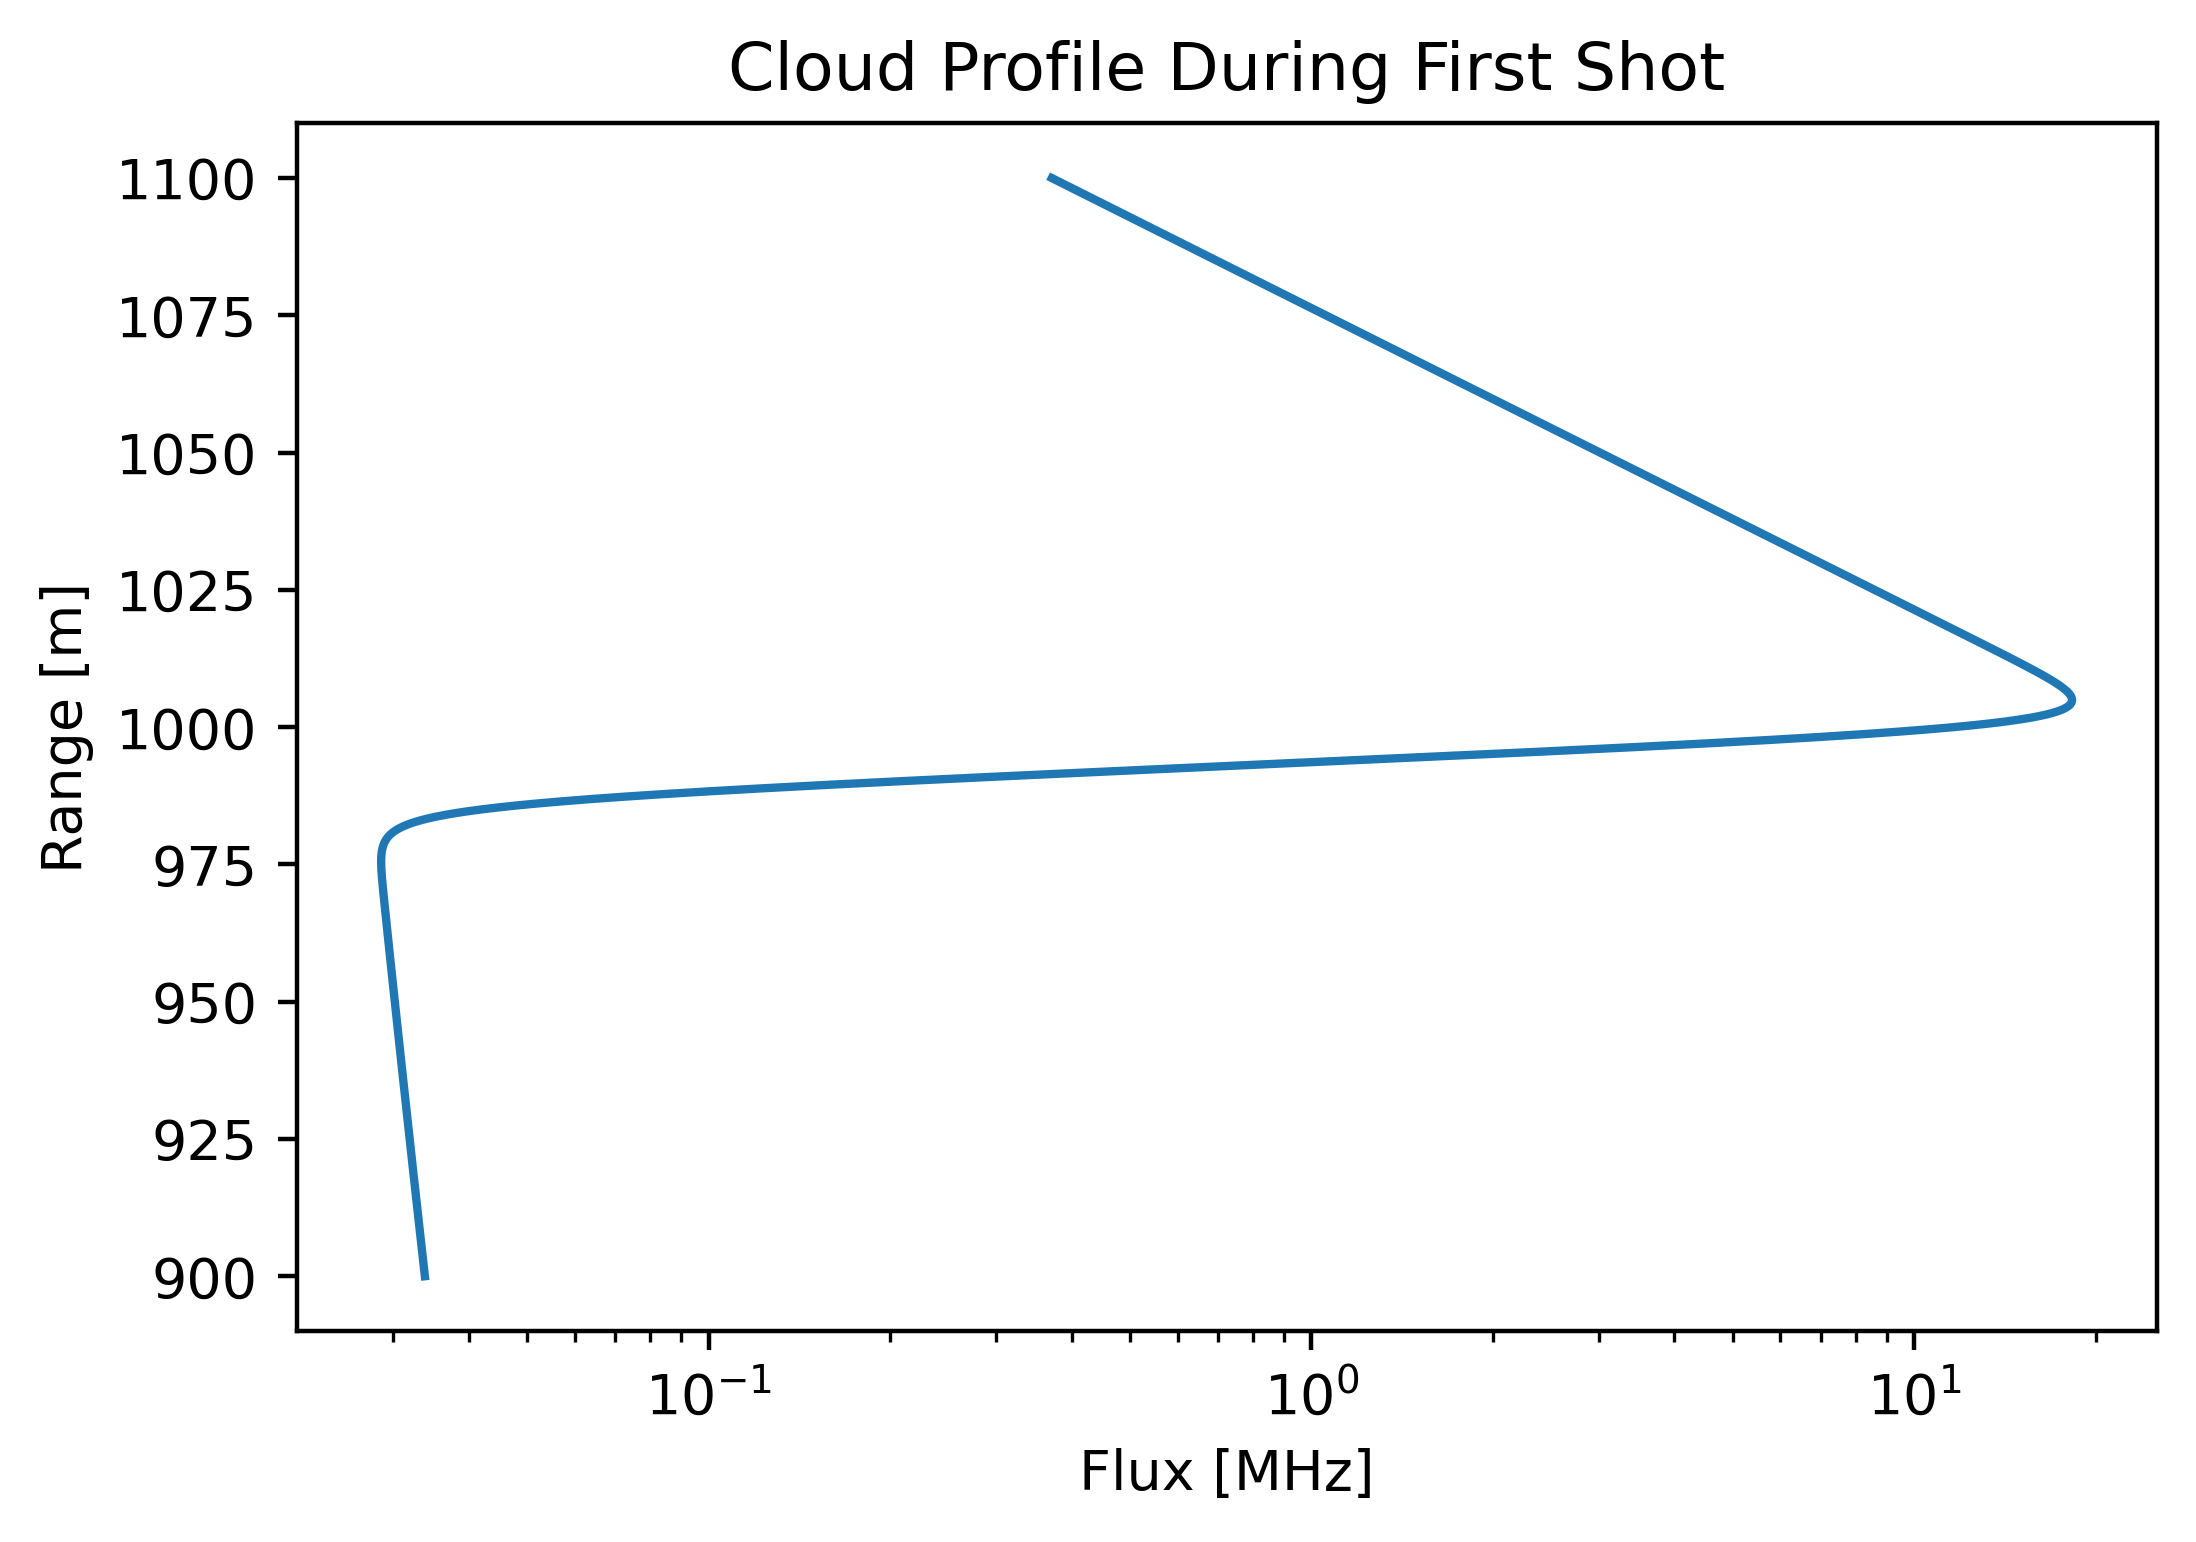

In [158]:
home = str(Path.home())
save_dir = home + r'\OneDrive - UCB-O365\ARSENL\Experiments\Cloud Measurements\Sims\saved_sims'

"""
Using Matthew Hayman's 'photon_count_generator' method in 'sim_deadtime_utils', generate simulated data with
and without deadtime effects.
:param t_sim_max: (float) maximum time for each laser shot [s]
:param dt_sim: (float) resolution settings [s]
:param tD: (float) deadtime [s]
:param Nshot: (int) number of laser shots
:param wrap_deadtime: (bool) set TRUE to wrap deadtime into next shot if detection is close to 't_sim_max'
:param window_bnd: (1x2 float list) time bounds on simulation [s]
:param rho_func: (1xlen(t_sim)) arrival-rate function [Hz]
:return: flight_time, true_flight_time, n_shots, t_det_lst, t_phot_lst
"""

if use_hg:
    N_com = N_com_HG
else:
    N_com = N_com_LG

if not use_window:
    window_bnd = [np.min(alt), np.max(alt)]  # [m] If not windowing, set window bounds to the max range
    
idx_low = np.argmin(np.abs(alt - window_bnd[0]))
idx_high = np.argmin(np.abs(alt - window_bnd[1]))

dt_sim = dt_TCSPC  # [s]
if use_hg:
    eta_BS = eta * T_BS_HG
else:
    eta_BS = eta * T_BS_LG
if not time_vary:
    if use_com:
        rho_func = N_com / dt_sim  # [Hz] arrival-rate function (flux)
    else:
        rho_func = N_mol / dt_sim  # [Hz] arrival-rate function (flux)
    # generate the photon arrival rate of the profile
    photon_rate_arr = rho_func  # [Hz]
    photon_rate_arr_first = photon_rate_arr[idx_low:idx_high] * 0.02  # [Hz]
else:
    if use_hg:
        photon_rate_arr_first = photon_rate_arr_HG[idx_low:idx_high]  # [Hz] really only for plotting right now for sanity check, since rho will be regenerated each loop in the next part
    else:
        photon_rate_arr_first = photon_rate_arr_LG[idx_low:idx_high]     

# Window relevant vectors
alt_w = alt[idx_low:idx_high]  # [m] 
R_w = alt_w - plat_height  # [m] range from system
# photon_rate_arr_w = photon_rate_arr[idx_low:idx_high]  # [Hz]
# beta_aer_w = beta_aer[idx_low:idx_high]
beta_mol_w = beta_mol[idx_low:idx_high]
alpha_mol_w = alpha_mol[idx_low:idx_high]
G_w = G[idx_low:idx_high]
   
T_laser = 1 / f_L  # [s] laser period
T_cloud_period = 2  # [s] period for sinusoidal varying cloud base

# Precompute cloud base location per shot
n = np.arange(0, Nshot)
t_step = n * T_laser  # [s]
loc = amp * np.sin(2*np.pi*t_step/T_cloud_period)  # [m] various places in cloud base
cloud_bot = 1000 + loc  # [m] cloud base

t_sim = R_w / c * 2  # [s] simulation time
t_sim_bins = np.concatenate((t_sim, t_sim[-1:]+dt_sim))  # simulation time histogram bins
# t_sim_bins[0] = 0    

min_t = min(t_sim_bins)  # [s]
t_sim_bins_zeroed = t_sim_bins - min_t  # [s] need to shift time axis to start at zero for simulator
        
fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)
ax.plot(photon_rate_arr_first/1e6, t_sim_bins[:-1]*c/2)
ax.set_ylabel('Range [m]')
ax.set_xlabel('Flux [MHz]')
ax.set_title('Cloud Profile During First Shot')
ax.set_xscale('log')
plt.show()

In [159]:
##### GENERATE SIMULATED DATA #####

# simulation resolution settings
if type(Nshot) != int:
    Nshot = int(Nshot)  # number of laser shots

# generate photon counts

# lists of photon arrivals per laser shot
start = time.time()
t_det_lst = []  # detected photons (includes deadtime)
t_phot_lst = []  # actual photons (no dead time)
sync_idx = np.arange(Nshot)  # sync value
det_sync_idx = []
phot_sync_idx = []
det_events = []
phot_events = []

t_det_last = -100.0  # last photon detection event
if time_vary:
    N_com_agg = np.zeros((len(alt_w), Nshot))
    cloud_sig_agg = np.zeros((len(alt_w), Nshot))
for n in range(Nshot):
    if time_vary:
        cloud_bot_step = cloud_bot[n]  # [m] cloud base
        
        photon_rate_arr, N_com, cloud = gen_cloud(alt_w, plat_height, cloud_bot_step, cloud_top, \
                                                      cloud_alpha, S, beta_aer, alpha_mol_w,\
                                                      beta_mol_w, dR, N_L, A, eta_BS, G_w, N_B,\
                                                      dt_TCSPC)
        
        photon_rate_arr *= 0.5
        N_com *= 0.5
        cloud *= 0.5
        
        N_com_agg[:, n] = N_com
        cloud_sig_agg[:, n] = cloud
    else:
        if n == 0:
            cloud_bot_step = cloud_bot[0]  # [m] cloud base (only use first location for entire sim)
            photon_rate_arr, N_com, cloud = gen_cloud(alt_w, plat_height, cloud_bot_step, cloud_top, \
                                                          cloud_alpha, S, beta_aer, alpha_mol_w,\
                                                          beta_mol_w, dR, N_L, A, eta_BS, G_w, N_B,\
                                                          dt_TCSPC)
            photon_rate_arr *= 0.02
            N_com *= 0.02
            cloud *= 0.02
    
    # simulate a laser shot
    ptime, ctime = sim.photon_count_generator(t_sim_bins_zeroed, photon_rate_arr, tau_d_flt=tD, last_photon_flt=t_det_last)
    if wrap_deadtime:
        if len(ctime) > 0:
            t_det_last = ctime[-1]
        t_det_last -= t_sim_bins[-1]

    ctime /= dt_sim  # convert from s to clock counts since sync event
    ptime /= dt_sim  # convert from s to clock counts since sync event

    for i in range(len(ctime)):
        det_events.append(ctime[i])  # detection time tags
        det_sync_idx.append(n)
    for i in range(len(ptime)):
        phot_events.append(ptime[i])  # photon time tags
        phot_sync_idx.append(n)

print('Time elapsed: {} s'.format(time.time()-start))

Time elapsed: 2235.2813766002655 s


In [160]:
# Save data out
det_idx = np.arange(len(det_events))
phot_idx = np.arange(len(phot_events))

time_tag_index = det_idx
true_time_tag_index = phot_idx
sync_index = sync_idx
time_tag = det_events + min_t/dt_sim
true_time_tag = phot_events + min_t/dt_sim
time_tag_sync_index = det_sync_idx
true_time_tag_sync_index = phot_sync_idx

if use_hg:
    T_BS = T_BS_HG
else:
    T_BS = T_BS_LG

# Save simulated data to netCDF
sim_data = xr.Dataset(
    data_vars=dict(
        time_tag=(['time_tag_index'], time_tag),
        time_tag_sync_index=(['time_tag_index'], time_tag_sync_index),
        true_time_tag=(['true_time_tag_index'], true_time_tag),
        true_time_tag_sync_index=(['true_time_tag_index'], true_time_tag_sync_index),
        photon_rate_arr=photon_rate_arr,
        dt_sim=dt_sim,
        dtime=tD,
        t_sim_bins=t_sim_bins,
        T_BS=T_BS,
        f_L = f_L
    ),
    coords=dict(
        sync_index=(['sync_index'], sync_index)
    )
)

fname = r'\simnum_{}_nshot{:.2E}_useHG{}_T{}.nc'.format(sim_num, Nshot, use_hg, T_BS)
sim_data.to_netcdf(save_dir+fname)

In [163]:
# Load data

# Constants
c = 299792458  # [m/s] speed of light

# Parameters
home = str(Path.home())
load_dir = os.path.join(home, 'OneDrive - UCB-O365', 'ARSENL', 'Experiments', 'Cloud Measurements', 'Sims', 'saved_sims')
# load_dir = home + r'\OneDrive - UCB-O365\ARSENL\Experiments\Digitization Tests\Sims\saved_sims'

fname = r'simnum_10_nshot1.00E+05_useHGTrue_T0.95.nc'

ds = xr.open_dataset(os.path.join(load_dir, fname))

phot_events = ds.true_time_tag.values
dt_sim = ds.dt_sim.values  # [s]
t_sim_bins = ds.t_sim_bins.values  # [s]
Nshot = ds.sync_index.values[-1] + 1
det_events = ds.time_tag.values
det_sync_idx = ds.time_tag_sync_index
phot_sync_idx = ds.true_time_tag_sync_index
photon_rate_arr = ds.photon_rate_arr.values
tD = ds.dtime.values  # [s] deadtime
f_L = ds.f_L.values  # [Hz] laser rep rate
# window_bnd = ds.window_bnd.values  # [m]

In [164]:
det_events = np.array(det_events)
phot_events = np.array(phot_events)

det_events_ordered = []
phot_events_ordered = []
for i in range(Nshot):
    det_idx = np.where(np.array(det_sync_idx)==i)[0]
    phot_idx = np.where(np.array(phot_sync_idx)==i)[0]
    if det_idx.size == 0:
        det_events_ordered.append([])
    else:
        det_events_shot = det_events[det_idx]
        det_events_ordered.append(det_events_shot)
    if phot_idx.size == 0:
        phot_events_ordered.append([])
    else:
        phot_events_shot = phot_events[phot_idx]
        phot_events_ordered.append(phot_events_shot)

In [174]:
alt_bins = t_sim_bins - 0.5*dR

range_avg = 7500
shot_avg = 5000

# Check that shot average is divisible by the number of shots
if Nshot % shot_avg != 0:
    print('Change "shot_avg" variable to divisible number!')
    
if type(shot_avg) != int:
    shot_avg = int(shot_avg)

In [175]:
dim_range = len(t_sim_bins[::range_avg][:-1])
curtain_det = np.zeros((dim_range, Nshot))
curtain_phot = np.zeros((dim_range, Nshot))
for i in range(Nshot):
    n, bins = np.histogram((np.array(det_events_ordered[i])*dt_TCSPC), bins=t_sim_bins[::range_avg])
    curtain_det[:, i] = n[::-1]
    
    n, _ = np.histogram((np.array(phot_events_ordered[i])*dt_TCSPC), bins=t_sim_bins[::range_avg])
    curtain_phot[:, i] = n[::-1]
    
rows, cols = curtain_det.shape
curtain_det = curtain_det.reshape(rows, cols//shot_avg, shot_avg).sum(axis=2)
curtain_phot = curtain_phot.reshape(rows, cols//shot_avg, shot_avg).sum(axis=2)

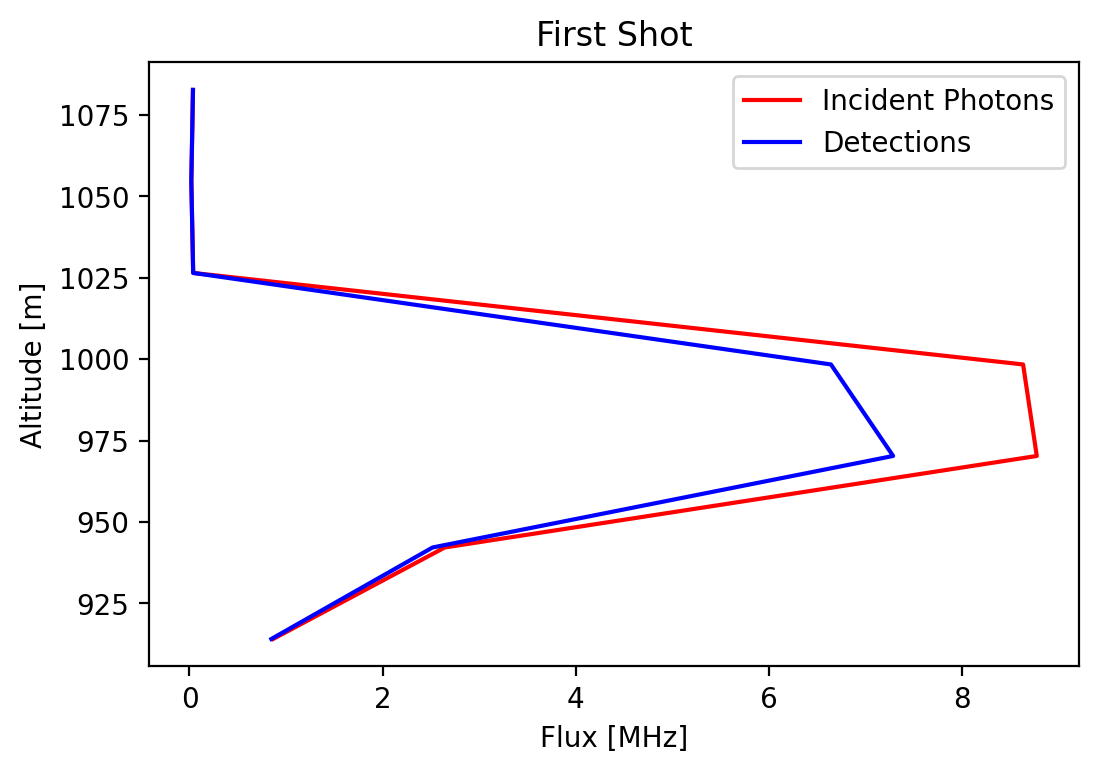

In [176]:
bwidth = np.diff(bins)[0]
centers = bins[:-1] + 0.5*bwidth  # [s]
centers = centers*c/2  # [m]

fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.plot(curtain_phot[:, 0]/shot_avg/bwidth/1e6, centers, 'r', label='Incident Photons')
ax.plot(curtain_det[:, 0]/shot_avg/bwidth/1e6, centers, 'b', label='Detections')
ax.set_ylabel('Altitude [m]')
ax.set_xlabel('Flux [MHz]')
ax.set_title('First Shot')
plt.legend()
plt.show()

Range Resolution: 28.1055 m
Time Resolution: 0.3401 s


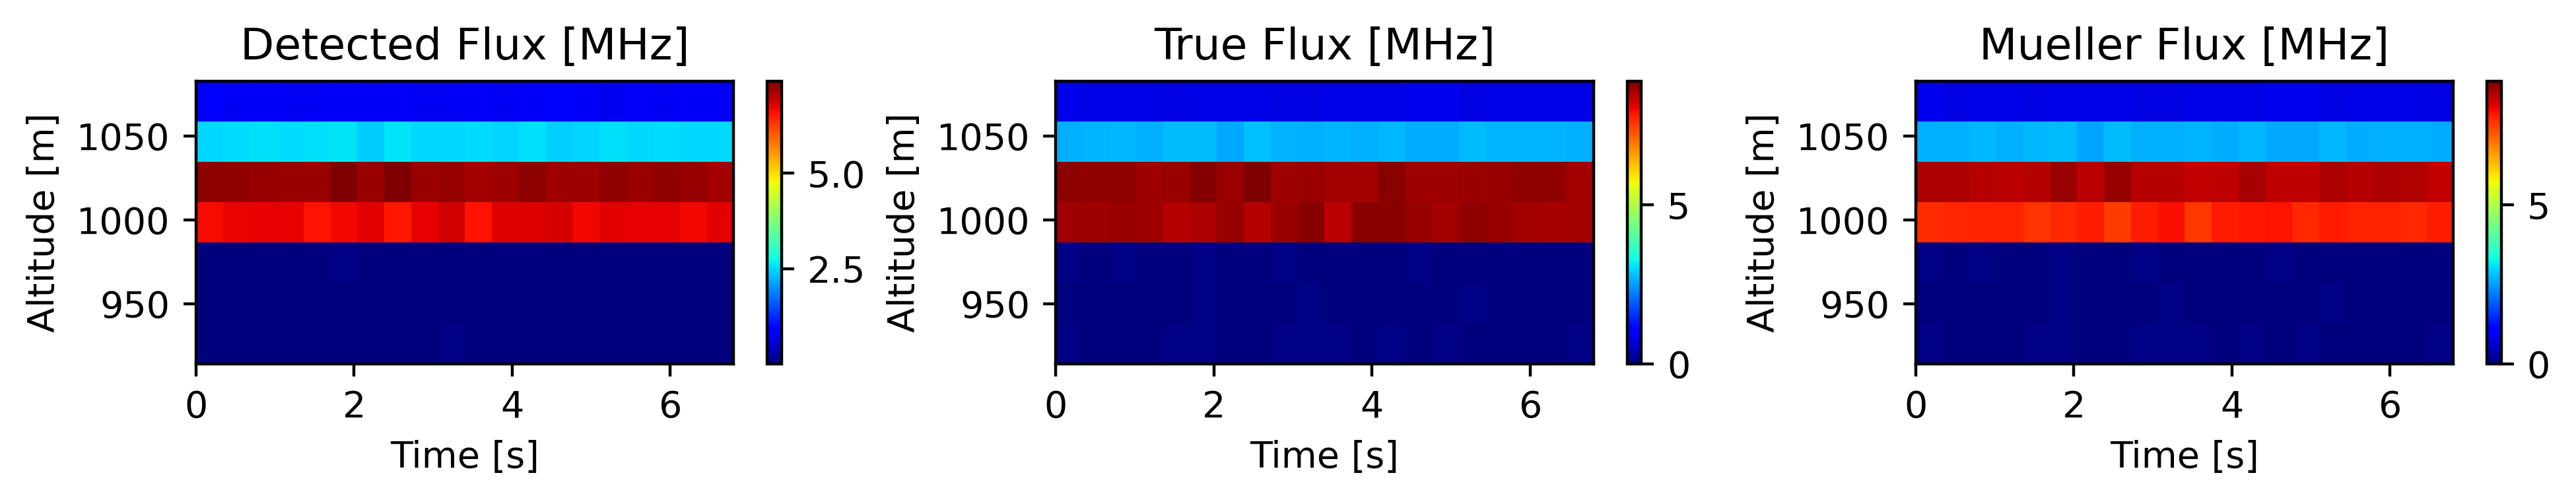

In [177]:
curtain_det_flux = curtain_det / bwidth / shot_avg  # [Hz] Detected flux
curtain_phot_flux = curtain_phot / bwidth / shot_avg  # [Hz] True flux
curtain_muller_flux = curtain_det_flux / (1-curtain_det_flux*tD)  # [Hz] Muller Corrected Flux
neg_vals = np.where(curtain_muller_flux < 0)
curtain_muller_flux[neg_vals] = np.nan

cmin_phot, cmax_phot = np.min(curtain_phot_flux), np.max(curtain_phot_flux)
cmin_det, cmax_det = np.min(curtain_det_flux), np.max(curtain_det_flux)
cmin_muller, cmax_muller = np.nanmin(curtain_muller_flux), np.nanmax(curtain_muller_flux)

print('Range Resolution: {:.4f} m'.format(bwidth*c/2))
print('Time Resolution: {:.4f} s'.format(shot_avg/f_L))

fig = plt.figure(figsize=(10,2), dpi=400)

ax = fig.add_subplot(131)
im = ax.imshow(curtain_det_flux/1e6, aspect='auto', extent=[0/f_L, (Nshot-1)/f_L, np.min(centers), np.max(centers)], cmap='jet')
im.set_clim(cmin_det/1e6, cmax_det/1e6)
ax.set_title('Detected Flux [MHz]')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Altitude [m]')
# ax.set_ylim([950, 1075])
plt.colorbar(im)

ax = fig.add_subplot(132)
im = ax.imshow(curtain_phot_flux/1e6, aspect='auto', extent=[0/f_L, (Nshot-1)/f_L, np.min(centers), np.max(centers)], cmap='jet')
im.set_clim(0, cmax_phot/1e6)
ax.set_title('True Flux [MHz]')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Altitude [m]')
# ax.set_ylim([950, 1075])
plt.colorbar(im)

ax = fig.add_subplot(133)
im = ax.imshow(curtain_muller_flux/1e6, aspect='auto', extent=[0/f_L, (Nshot-1)/f_L, np.min(centers), np.max(centers)], cmap='jet')
im.set_clim(0, cmax_phot/1e6)
ax.set_title('Mueller Flux [MHz]')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Altitude [m]')
# ax.set_ylim([950, 1075])
plt.colorbar(im)
plt.tight_layout()
plt.show()

In [84]:
n, bins = np.histogram((np.array(det_events)*dt_TCSPC), bins=[t_sim_bins_zeroed[::range_avg], alt_bins[::shot_avg]])
binwidth = np.diff(bins)[0]
N_det = n / binwidth / Nshot  # [Hz]

n, bins = np.histogram((np.array(phot_events)*dt_TCSPC), bins=t_sim_bins_zeroed[::range_avg], alt_bins[::shot_avg])
binwidth = np.diff(bins)[0]
N_phot = n / binwidth / Nshot  # [Hz]
center = 0.5 * (bins[:-1] + bins[1:])

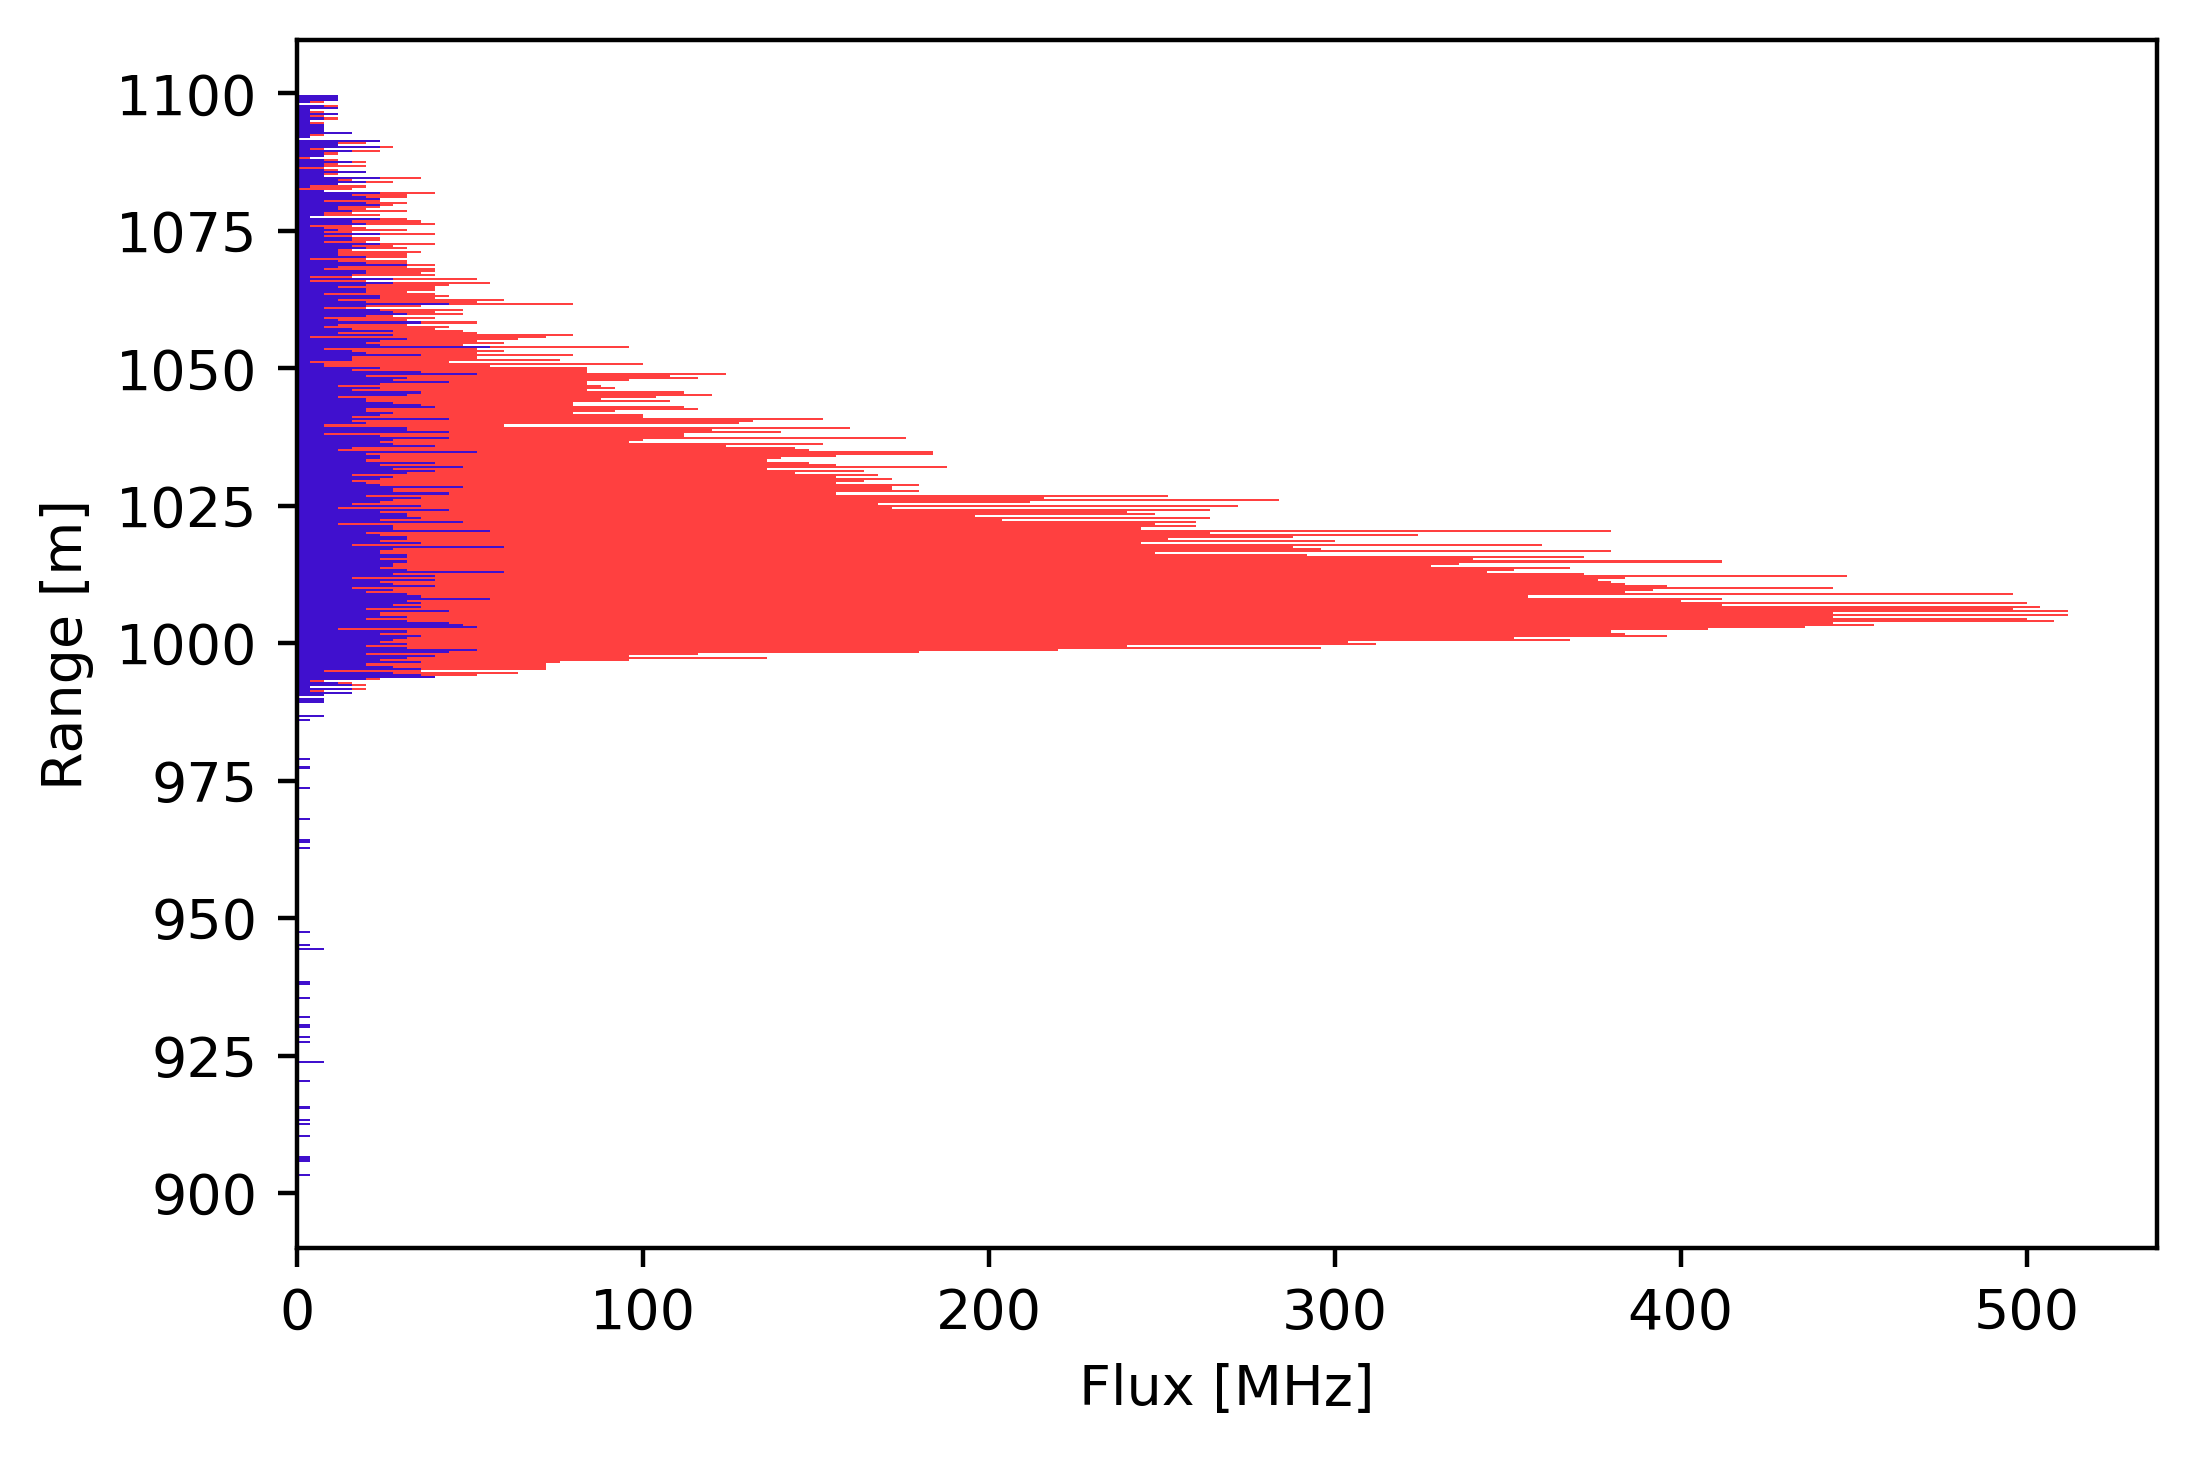

In [85]:
fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)
ax.barh((center+min_t)*c/2, N_phot/1e6, align='center', height=binwidth*c/2, color='r', alpha=0.75, label='Detections')
ax.barh((center+min_t)*c/2, N_det/1e6, align='center', height=binwidth*c/2, color='b', alpha=0.75, label='Detections')
ax.set_ylabel('Range [m]')
ax.set_xlabel('Flux [MHz]')
plt.show()

In [27]:
# Save data out
det_idx = np.arange(len(det_events))
phot_idx = np.arange(len(phot_events))

time_tag_index = det_idx
true_time_tag_index = phot_idx
sync_index = sync_idx
time_tag = det_events + min_t/dt_sim
true_time_tag = phot_events + min_t/dt_sim
time_tag_sync_index = det_sync_idx
true_time_tag_sync_index = phot_sync_idx

if use_hg:
    T_BS = T_BS_HG
else:
    T_BS = T_BS_LG

# Save simulated data to netCDF
sim_data = xr.Dataset(
    data_vars=dict(
        time_tag=(['time_tag_index'], time_tag),
        time_tag_sync_index=(['time_tag_index'], time_tag_sync_index),
        true_time_tag=(['true_time_tag_index'], true_time_tag),
        true_time_tag_sync_index=(['true_time_tag_index'], true_time_tag_sync_index),
        photon_rate_arr=photon_rate_arr,
        dt_sim=dt_sim,
        dtime=tD,
        t_sim_bins=t_sim_bins,
        T_BS=T_BS
    ),
    coords=dict(
        sync_index=(['sync_index'], sync_index)
    )
)

fname = r'\simnum_{}_nshot{:.2E}_useHG{}_T{}.nc'.format(sim_num, Nshot, use_hg, T_BS)
sim_data.to_netcdf(save_dir+fname)

In [ ]:
bin_avg = 1000  # integration factor (increase bin sizes)

fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)
n, bins = np.histogram((np.array(phot_events)*dt_sim + min_t), bins=t_sim_bins[::bin_avg])
binwidth = np.diff(bins)[0]
N = n / binwidth / Nshot  # [Hz]
center = 0.5 * (bins[:-1] + bins[1:])
ax.bar(center*c/2, N, align='center', width=binwidth*c/2, color='r', alpha=0.75, label='Actual')

tof = (np.array(det_events)*dt_sim  + min_t)
n, bins = np.histogram(tof, bins=t_sim_bins[::bin_avg])
N = n / binwidth / Nshot  # [Hz] Scaling counts to arrival rate
ax.bar(center*c/2, N, align='center', width=binwidth*c/2, color='b', alpha=0.75, label='Measured')
if use_window:
    t_sim_plot = t_sim[idx_min:idx_max]
    if use_com:
        N_com_plot = N_com[idx_min:idx_max]
    else:
        N_mol_plot = N_mol[idx_min:idx_max]
if use_com:
#     if time_vary:
#         ax.plot(t_sim*c/2, np.mean(N_com_agg, axis=1)/dt_TCSPC, 'r--', alpha=0.35, label='Truth (mean)')
#         ax.plot(t_sim*c/2, N_com_agg[:, ::100]/dt_TCSPC)
#     else:
#         ax.plot(t_sim*c/2, N_com/dt_TCSPC, 'k--', alpha=0.6, label='Truth')

    if use_hg:
        ax.plot(t_sim_plot*c/2, N_com_plot/dt_TCSPC, 'k--', alpha=0.6, label='Truth (high gain T={})'.format(T_BS_HG))
        ax.plot(t_sim_plot*c/2, N_com_plot/dt_TCSPC/T_BS_HG, 'm--', alpha=0.6, label='Truth')
    else:
        ax.plot(t_sim_plot*c/2, N_com_plot/dt_TCSPC, 'k--', alpha=0.6, label='Truth (low gain T={})'.format(T_BS_LG))
        ax.plot(t_sim_plot*c/2, N_com_plot/dt_TCSPC/T_BS_LG, 'm--', alpha=0.6, label='Truth')
else:
    ax.plot(t_sim_plot*c/2, N_mol_plot/dt_TCSPC, 'r--', alpha=0.5, label='Truth')
ax.set_ylabel('Flux [Hz]')
ax.set_xlabel('Altitude [m]')
ax.set_title('Simulated Measurements of Cloud Edge')
ax.set_yscale('log')
# ax.set_xlim([250, 1400])
# ax.set_ylim([1e4, 1e9])
plt.tight_layout()
plt.legend()
plt.show()


# Graveyard

In [37]:
# start = time.time()

# # alt_tile = np.tile(alt_window, (Nshot, 1)).T  # [m] preparing altitude vector for each profile
# # cloud_sig_agg = (1 / (1+np.exp(-cloud_alpha*(alt_tile-cloud_bot)))) - (1 / (1+np.exp(-cloud_alpha*(alt_tile-cloud_top))))

# for i in range(len(loc)):
#     # Change cloud base location
#     cloud_bot_step = cloud_bot[i]  # [m] cloud base
#     cloud_sig = (1 / (1+np.exp(-cloud_alpha*(alt_window-cloud_bot_step)))) - (1 / (1+np.exp(-cloud_alpha*(alt_window-cloud_top))))
#     cloud_sig_agg[:, i] = cloud * cloud_sig
# print('Time elapsed: {:.2f} s'.format(time.time()-start))

# num = 20
# t_part = n[::int(len(cloud_sig_agg[0, :])/num)] * T_laser
# cloud_sig_agg_part = cloud_sig_agg[:, ::int(len(cloud_sig_agg[0, :])/num)][::-1]
# fig = plt.figure(dpi=400, figsize=(1, 4))
# ax = fig.add_subplot(111)
# im = ax.imshow(cloud_sig_agg_part, aspect='auto', extent=[np.min(t_part)*1e3, np.max(t_part)*1e3, np.min(alt_window), np.max(alt_window)])
# ax.set_ylim([990, 1010])
# ax.set_xlabel('Time [ms]')
# ax.set_ylabel('Altitude [m]')
# plt.colorbar(im)
# plt.show()

In [ ]:
# # # cloud_alpha = 0.035 # smooth transition
# cloud_sig = (1 / (1+np.exp(-cloud_alpha*(alt-cloud_bot)))) - (1 / (1+np.exp(-cloud_alpha*(alt-cloud_top))))

# # S = 20  # [sr] lidar ratio
# # # S = 40  # [sr] try this for rapid extinction
# # beta_aer = 1e-3  # [m-1 sr-1] singular value for aerosol backscatter

# # # Double-sigmoid cloud
# cloud = np.ones(len(alt))
# cloud *= cloud_sig

# # beta_aer = beta_aer * cloud  # [m-1 sr-1]
# # alpha_aer = S * beta_aer  # [m-1]

# # cloud = gen_cloud(alt, cloud_bot, cloud_top, cloud_alpha, S, beta_aer)

# # Lidar equation for combined molecular and aerosol backscatter
# plat_height = 0  # [m] Assume transmitter and receiver are at the surface
# R = alt - plat_height  # [m]

# trans = np.exp(-np.cumsum((alpha_mol+alpha_aer)*dR))

# N_com_LG = N_L*(beta_mol+beta_aer)*dR*A/R**2*trans**2*eta*T_BS_LG*G + N_B
# N_com_HG = N_L*(beta_mol+beta_aer)*dR*A/R**2*trans**2*eta*T_BS_HG*G + N_B

# # Remove first term (unreal, 0 km alt)
# N_com_LG[0] = 0
# N_com_HG[0] = 0

# # Unaccounted missed photons
# N_com_LG /= 10
# N_com_HG /= 10

# N_com_LG_tot = np.sum(N_com_LG)
# N_com_HG_tot = np.sum(N_com_HG)

# print('Total low gain photons: {:.2E}'.format(N_com_LG_tot))
# print('Total high gain photons: {:.2E}'.format(N_com_HG_tot))

# # Check cloud + mol signal

# fig = plt.figure(figsize=(4, 4.5), dpi=400)
# ax = fig.add_subplot(111)
# ax.plot(N_com_HG/dt_TCSPC/1e6, R/1e3, '-', linewidth=8)
# ax.set_ylabel('Altitude [km]')
# ax.set_xlabel('Flux [MHz]')
# ax.set_title('Cloud Edge Backscatter')
# ax.set_xlim([4e-1, 3e3])
# ax.set_ylim([0.94, 1.05])
# ax.fill_between([4e-1, 3e3], 0.9875, 1.00, alpha=0.5)
# ax.set_xscale('log')
# plt.tight_layout()
# plt.show()